<a href="https://colab.research.google.com/github/adliaulia/Cityscape-image-segmentation/blob/main/Cityscape-semantic-segmentation_Adli-Aulia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Building Intelligent AI To Segment Objects**
**Indonesia AI Mentorship - Computer Vision 14**</br>
->Adli Aulia Fattah H

Dataset: Cityscapes Dataset</br>
The data contains in the form of
1.   Images
2.   Annotations

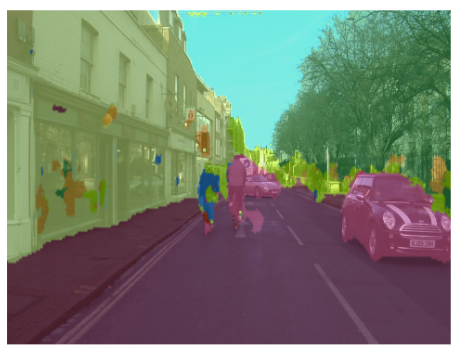

**11 Labels of the annotation**

0 = background
1.   Sky
2.   Building
3.   Pole
4.   Road
5.   Pavement
6.   Tree
7.   SignSymbol
8.   Fence
9.   Car
10.   Pedestrian
11.   Bicyclist


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow
import glob

In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPU Available:  1


# Acquisition Dataset

## ImportImages & Annotations

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

GDRIVE_PATH = '/content/drive/MyDrive/'

%ls

Mounted at /content/drive
drive/  sample_data/


In [4]:
IMAGES_X_TRAIN_PATH = "Course Indonesia AI - CV/Dataset/Final-project/images_prepped_train/" #dir_x, # 367 images
IMAGES_X_TEST_PATH = "Course Indonesia AI - CV/Dataset/Final-project/images_prepped_test/"

IMAGES_Y_TRAIN_PATH = "Course Indonesia AI - CV/Dataset/Final-project/annotations_prepped_train/" #dir_y, # 101 images
IMAGES_Y_TEST_PATH = "Course Indonesia AI - CV/Dataset/Final-project/annotations_prepped_test/" 

images_train_filename = os.listdir(os.path.join(GDRIVE_PATH, IMAGES_X_TRAIN_PATH))
images_test_filename = os.listdir(os.path.join(GDRIVE_PATH, IMAGES_X_TEST_PATH))

In [5]:
print(images_train_filename)
print(images_test_filename)

['0016E5_01410.png', '0001TP_008280.png', '0006R0_f03540.png', '0016E5_05880.png', '0001TP_007260.png', '0006R0_f02220.png', '0001TP_008370.png', '0006R0_f01680.png', '0016E5_05400.png', '0016E5_06330.png', '0001TP_008130.png', '0016E5_04830.png', '0016E5_08550.png', '0016E5_06570.png', '0006R0_f02820.png', '0006R0_f01500.png', '0006R0_f03300.png', '0006R0_f02040.png', '0016E5_01050.png', '0006R0_f00930.png', '0016E5_07770.png', '0006R0_f03150.png', '0016E5_06000.png', '0016E5_02010.png', '0006R0_f03630.png', '0016E5_08280.png', '0006R0_f02370.png', '0016E5_04470.png', '0016E5_01620.png', '0001TP_007710.png', '0016E5_06240.png', '0016E5_05730.png', '0016E5_04650.png', '0016E5_06930.png', '0006R0_f03060.png', '0016E5_04620.png', '0001TP_008310.png', '0016E5_06750.png', '0006R0_f01260.png', '0006R0_f01320.png', '0016E5_05460.png', '0001TP_007020.png', '0006R0_f02670.png', '0006R0_f01950.png', '0001TP_007980.png', '0016E5_05250.png', '0016E5_06360.png', '0016E5_08250.png', '0001TP_006870.

## Load the Dataset

In [6]:
def preprocess_data(filename, dir_x, dir_y, SHAPE = 416):
  # cv2.imread(path, flag). Using 0 to read image in grayscale mode
  image_x = cv2.imread(dir_x + filename, 0)
  image_y = cv2.imread(dir_y + filename, 0)

  #reshaping image to 224x224
  image_x = cv2.resize(image_x, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST) 
  image_y = cv2.resize(image_y, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  return image_x, image_y

In [7]:
IMAGES_TRAIN_ARR = []
ANNOTATIONS_TRAIN_ARR = []
IMAGES_TEST_ARR = []
ANNOTATIONS_TEST_ARR = []

for filename in images_train_filename:
  img_x, img_y = preprocess_data(filename, os.path.join(GDRIVE_PATH, IMAGES_X_TRAIN_PATH), os.path.join(GDRIVE_PATH, IMAGES_Y_TRAIN_PATH))
  IMAGES_TRAIN_ARR.append(img_x)
  ANNOTATIONS_TRAIN_ARR.append(img_y)

for filename in images_test_filename:
  img_x, img_y = preprocess_data(filename, os.path.join(GDRIVE_PATH, IMAGES_X_TEST_PATH), os.path.join(GDRIVE_PATH, IMAGES_Y_TEST_PATH))
  IMAGES_TEST_ARR.append(img_x)
  ANNOTATIONS_TEST_ARR.append(img_y)

IMAGES_TRAIN_ARR = np.array(IMAGES_TRAIN_ARR)
ANNOTATIONS_TRAIN_ARR = np.array(ANNOTATIONS_TRAIN_ARR)
IMAGES_TEST_ARR = np.array(IMAGES_TEST_ARR)
ANNOTATIONS_TEST_ARR = np.array(ANNOTATIONS_TEST_ARR)

In [8]:
print('IMAGES TRAIN ARRAY SHAPE:', IMAGES_TRAIN_ARR.shape)
print('ANNOTA TRAIN ARRAY SHAPE:', ANNOTATIONS_TRAIN_ARR.shape)
print('IMAGES TEST ARRAY SHAPE:', IMAGES_TEST_ARR.shape)
print('ANNOTA TEST ARRAY SHAPE:', ANNOTATIONS_TEST_ARR.shape)

IMAGES TRAIN ARRAY SHAPE: (367, 416, 416)
ANNOTA TRAIN ARRAY SHAPE: (367, 416, 416)
IMAGES TEST ARRAY SHAPE: (101, 416, 416)
ANNOTA TEST ARRAY SHAPE: (101, 416, 416)


# Data Preprocessing

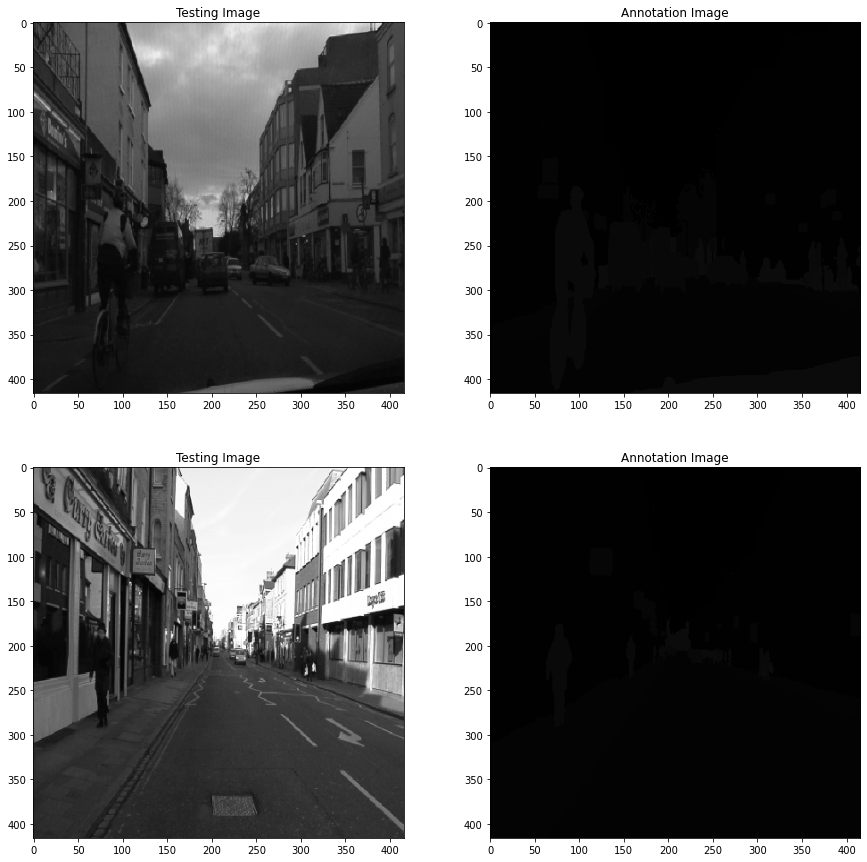

In [9]:
# plot training images
plt.figure(figsize=(15,15))
for i in range(1, 4, 2):
  plt.subplot(2, 2, i)
  plt.imshow(IMAGES_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Testing Image')
  plt.subplot(2, 2, i+1)
  plt.imshow(ANNOTATIONS_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Annotation Image')
plt.show()

In [10]:
# function to get unique values
def get_class(image_y):
  array = image_y.ravel()
  return np.unique(array)

In [11]:
# get information from the dataset
print('image prepped train shape:', IMAGES_TRAIN_ARR.shape)
print('annotations prepped train shape:', ANNOTATIONS_TRAIN_ARR.shape)
print('image prepped test shape:', IMAGES_TEST_ARR.shape)
print('annotations prepped test shape:', ANNOTATIONS_TEST_ARR.shape)
print('data train:', len(IMAGES_TRAIN_ARR))
print('data test:', len(IMAGES_TEST_ARR))

print('\n')
print("unique value of 'annotation'")
print("kind of class :", get_class(ANNOTATIONS_TRAIN_ARR[2]))
print("number of classes:", len(get_class(ANNOTATIONS_TRAIN_ARR[2])))

print('\n')
print("unique value of 'image'")
print("kind of class :\n", get_class(IMAGES_TRAIN_ARR[2]))
print("number of classes:", len(get_class(IMAGES_TRAIN_ARR[2])))

image prepped train shape: (367, 416, 416)
annotations prepped train shape: (367, 416, 416)
image prepped test shape: (101, 416, 416)
annotations prepped test shape: (101, 416, 416)
data train: 367
data test: 101


unique value of 'annotation'
kind of class : [ 0  1  2  3  4  5  6  7  8  9 10 11]
number of classes: 12


unique value of 'image'
kind of class :
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 

## Normalize Data

In [12]:
# Data train
x = np.expand_dims(IMAGES_TRAIN_ARR, axis=3)
train_x_norm = normalize(x.reshape(x.shape[0],-1), axis=1).reshape(x.shape)
train_y_norm = np.expand_dims(ANNOTATIONS_TRAIN_ARR, axis=3)

# # Data test
y = np.expand_dims(IMAGES_TEST_ARR, axis=3)
test_x_norm = normalize(y.reshape(y.shape[0],-1), axis=1).reshape(y.shape)
test_y_norm = np.expand_dims(ANNOTATIONS_TEST_ARR, axis=3)

In [13]:
# after normalization data
print('Train images shape:', train_x_norm.shape)
print('Train annots shape:', train_y_norm.shape)
print('Test images shape:', test_x_norm.shape)
print('Test annots shape:', test_y_norm.shape)

Train images shape: (367, 416, 416, 1)
Train annots shape: (367, 416, 416, 1)
Test images shape: (101, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)


## Split Dataset

In [14]:
# split train data -> train & validation data 
train_x, val_x, train_y, val_y = train_test_split(train_x_norm, train_y_norm, test_size=0.1, random_state=14)
print('Train images shape:', train_x.shape)
print('Valid images shape:', val_x.shape)
print('Train annots shape:', train_y.shape)
print('Valid images shape:', val_y.shape)

# test = test_norm
test_x, test_y = test_x_norm, test_y_norm
print('Test annots shape:', test_x.shape)
print('Test images shape:', test_y.shape)

Train images shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Train annots shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)
Test images shape: (101, 416, 416, 1)


## Encode Annotations Dataset

In [15]:
# num of classes
n_classes = 12

# One Hot Encoding Train Data Annotation
train_y_cat = keras.utils.to_categorical(train_y, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = keras.utils.to_categorical(val_y, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

In [16]:
# after encode annotations dataset
print('Class values in the dataset are:', get_class(train_y[0]))
print('Train images shape', train_x.shape)
print('Train labels shape', train_y_cat.shape)

print('\nClass values in the dataset are:', get_class(val_y[0]))
print('Validation images shape', val_x.shape)
print('Validation labels shape', val_y_cat.shape)

print('\nClass values in the dataset are:', get_class(test_y[0]))
print('Test images shape', test_x.shape)
print('Test labels shape', test_y_cat.shape)

Class values in the dataset are: [ 0  1  2  3  4  5  6  8  9 10 11]
Train images shape (330, 416, 416, 1)
Train labels shape (330, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  8  9 11]
Validation images shape (37, 416, 416, 1)
Validation labels shape (37, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test images shape (101, 416, 416, 1)
Test labels shape (101, 416, 416, 12)


# Build the Model
Using FCN or UNet

In [ ]:
def UNet(image_size, ch_in=1, ch_out=3):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # The Contraction Path
  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # The Bottleneck Path
  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) #Dropout sifatnya opsional

  # The Expansion Path
  # Blok 6
  up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(dropout5))
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Blok 7
  up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Blok 8
  up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Blok 9
  up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  # jumlah unit = jumlah class = pada kasus ini 2
  unit = 12
  conv10 = Conv2D(unit, 1, activation='relu')(conv9)
  conv10 = Conv2D(unit, 1, activation='softmax')(conv10)

  outputs = conv10

  model = Model(inputs, outputs)
  
  return model

In [ ]:
model = UNet(image_size=(416, 416))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 416, 416, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 416, 416, 64  640         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 416, 416, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

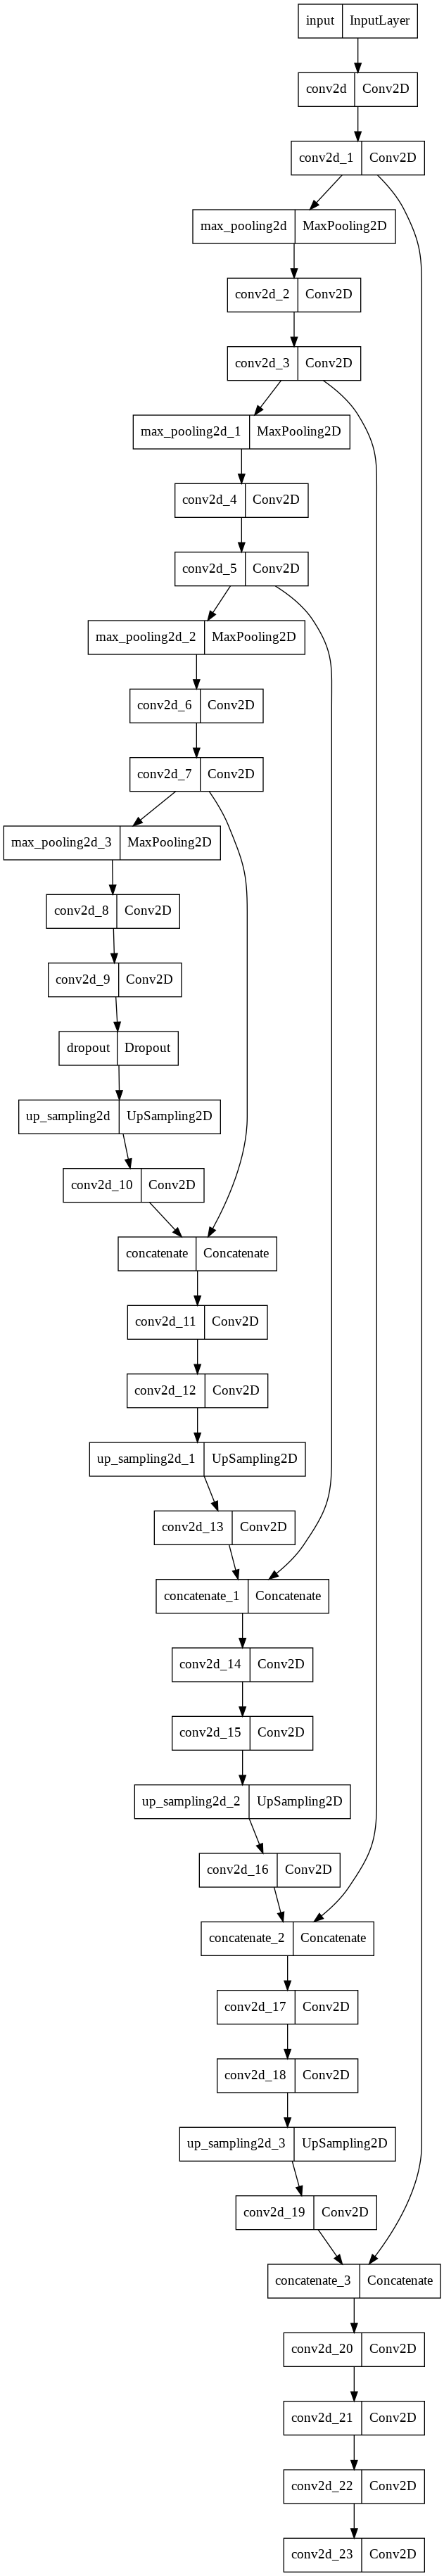

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

## Train the Model

In [ ]:
# from re import VERBOSE
# Train training ke-
iter = 3
batch_size = 4
epoch = 100

# Checkpoint
MODEL_DIRECTORY = GDRIVE_PATH + "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Model/"
MODEL_NAME = f'my_model-{iter}.h5'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH, 
                                                            monitor='val_accuracy', 
                                                            mode='max', 
                                                            save_best_only=True)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.0001, verbose = 1, restore_best_weights = True)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
83/83 [==============================] - 73s 862ms/step - loss: 1.3018 - accuracy: 0.5538 - val_loss: 1.2437 - val_accuracy: 0.5941
Epoch 2/100
83/83 [==============================] - 68s 821ms/step - loss: 1.2705 - accuracy: 0.5720 - val_loss: 1.2326 - val_accuracy: 0.5843
Epoch 3/100
83/83 [==============================] - 71s 856ms/step - loss: 1.2216 - accuracy: 0.6083 - val_loss: 1.1468 - val_accuracy: 0.6414
Epoch 4/100
83/83 [==============================] - 71s 857ms/step - loss: 1.2185 - accuracy: 0.6161 - val_loss: 1.1476 - val_accuracy: 0.6474
Epoch 5/100
83/83 [==============================] - 71s 858ms/step - loss: 1.1659 - accuracy: 0.6309 - val_loss: 1.0932 - val_accuracy: 0.6615
Epoch 6/100
83/83 [==============================] - 68s 819ms/step - loss: 1.1322 - accuracy: 0.6376 - val_loss: 1.0888 - val_accuracy: 0.6611
Epoch 7/100
83/83 [==============================] - 71s 862ms/step - loss: 1.1007 - accuracy: 0.6451 - val_loss: 1.0263 - val_accuracy:

## Plot Figure Training and Validation

saving figure to:


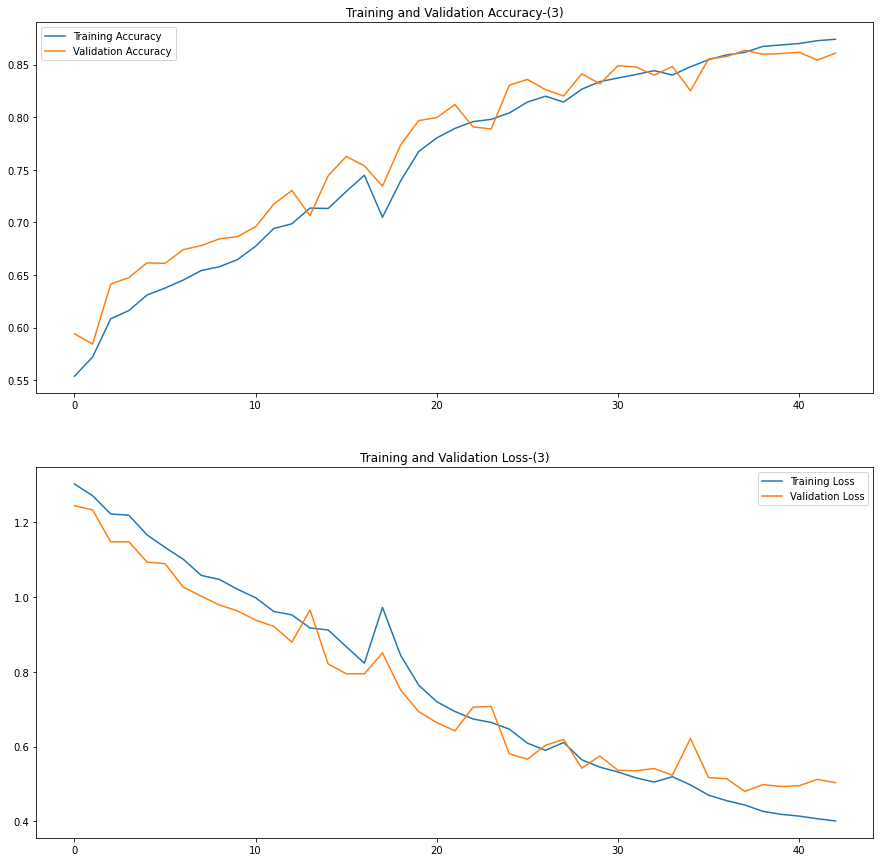

In [ ]:
# Plot training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy-({iter})')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')

plt.title(f'Training and Validation Loss-({iter})')

# save figure
PATH_FIGURE = "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Figure/"
dir_name = os.path.join(GDRIVE_PATH, PATH_FIGURE)
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
print('saving figure to:')
plt.savefig(f"Training and validation-{iter}.png")

plt.show()

## Save the Model Manually

In [ ]:
# saving the model manually
'''
MODEL_DIRECTORY = GDRIVE_PATH + "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Model/"
MODEL_NAME = f'my_model-{iter}.h5'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)

model.save(DIRECTORY_PATH)
print('Saved trained model at %s ' % MODEL_PATH)
'''

'\nMODEL_DIRECTORY = GDRIVE_PATH + "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Model/"\nMODEL_NAME = f\'my_model-{iter}.h5\'\nMODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)\n\nmodel.save(DIRECTORY_PATH)\nprint(\'Saved trained model at %s \' % MODEL_PATH)\n'

# Load the Model

In [17]:
# View the models stored in the model directory
MODEL_DIRECTORY = GDRIVE_PATH + "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Model/"
MODEL_LISTDIR = os.listdir(MODEL_DIRECTORY)
MODEL_LISTDIR

['my_model-2.h5', 'my_model-3.h5', 'my_model-1.h5']

In [18]:
# load the model and weight
LOADMODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_LISTDIR[2])
load_model = keras.models.load_model(LOADMODEL_PATH)
print('Loaded trained model at %s' %LOADMODEL_PATH)

Loaded trained model at /content/drive/MyDrive/Course Indonesia AI - CV/Pertemuan 8 - Final Project/Model/my_model-1.h5


## Evaluate the Model

In [19]:
# Evaluate the model with the same amount of validation data
# test_x_norm[:37], test_y_cat[:37]
score = load_model.evaluate(test_x[:10], test_y_cat[:10], verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8313700556755066
Test accuracy: 0.7898085117340088


## Check the Model Prediction

In [24]:
n_classes=12
# give color annota img
def give_color_to_annota_img(annota_img):
  random_colors = []

  for i in range(5000):
    random.seed(i)
    randColor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    random_colors.append(randColor)

  annota_img_zeros = np.zeros((416, 416, 3))
  for j in range(n_classes):
    annota_img_zeros[:, :, 0] += ((annota_img[:, :, 0] == j)*(random_colors[j][0])).astype('uint8')
    annota_img_zeros[:, :, 1] += ((annota_img[:, :, 0] == j)*(random_colors[j][1])).astype('uint8')
    annota_img_zeros[:, :, 2] += ((annota_img[:, :, 0] == j)*(random_colors[j][2])).astype('uint8')

  annota_img_zeros = cv2.cvtColor(np.array(annota_img_zeros, dtype=np.uint8), cv2.COLOR_BGR2RGB)
  return annota_img_zeros

# plot grayscale img
def plot_img(input_img, title='', iter=0):
  N_ch = input_img.shape[2]
  if N_ch == 1:
    plt.imshow(input_img[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title(title + f' {[iter]}')
  elif N_ch == 3:
    plt.imshow(input_img)
    plt.title(title + f' {[iter]}')
  else:
    print('error image')
    return
  # set the spacing between subplots
  plt.subplots_adjust(bottom=0.1, top=0.5)

# invert encoding (to_categorical) to original data
def invert_from_cat(img_cat):
  inverted = tf.keras.backend.argmax(img_cat)
  inverted_1dims = np.expand_dims(inverted, axis=2)
  return inverted_1dims

# preprocessing to predict
def prepare(filename):
  IMAGE_CHANNEL = 1 # or 3
  IMG_SIZE = 416
  new_array = cv2.resize(filename, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

# IoU of Each Class
def get_IoU_of_class(annota_img, pred_img):
  from keras.metrics import MeanIoU
  val,sum3 = 0,0
  IoU_arr = []
  IoU_keras = MeanIoU(num_classes=n_classes)
  IoU_keras.update_state(annota_img, pred_img)
  values = np.array(IoU_keras.get_weights()).reshape(n_classes, n_classes)
  print("IoU of Each Class:")
  for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    for k in range(n_classes):
        if k != i:
            sum2 = values[k, i] + sum2  
        else:
            continue
    sum3 = sum1 + sum2
    IoU_arr.append(val/sum3)
    print(f"IoU Class {i}: {val/sum3*100:.2f}%") 
  print(f"Mean IoU: {IoU_keras.result().numpy()*100:.2f}%")

  plt.figure(figsize=(8, 5))
  plt.bar(np.arange(0, len(IoU_arr)), IoU_arr)
  plt.xticks(np.arange(0, len(IoU_arr)))
  plt.ylabel("IoU")
  plt.xlabel("Class")
  plt.title("IoU of Each Class")

# Function to predict
# input: 1 image from test_x & test_y_cat
def predict_annotation(img_x, img_y, iter=0):
  # inverse from normalize data
  grayscale_img = img_x*255*255

  # predict image
  prediction = load_model.predict([prepare(img_x)])
  prediction_reshape = prediction.reshape((416, 416, 12)) # test_y_cat[0].shape

  # invert predict from categorical
  pred_invert = invert_from_cat(prediction_reshape)
  annota_img = invert_from_cat(img_y)

  # give color to pred_invert image
  colored_annota_img = give_color_to_annota_img(annota_img)
  colored_pred = give_color_to_annota_img(pred_invert)

  # masked image
  grayscale_img3ch = np.zeros((416, 416, 3))
  grayscale_img3ch = np.expand_dims(grayscale_img3ch, axis=3)

  grayscale_img3ch[:,:,0] += grayscale_img
  grayscale_img3ch[:,:,1] += grayscale_img
  grayscale_img3ch[:,:,2] += grayscale_img
  grayscale_img3ch2 = grayscale_img3ch.reshape(grayscale_img3ch.shape[0],grayscale_img3ch.shape[1], grayscale_img3ch.shape[2])
  masked_image = cv2.addWeighted(np.array(grayscale_img3ch2, dtype=np.uint8), 0.5, np.array(colored_pred, dtype=np.uint8), 0.5, 0)

  # plot image
  img_arr = [grayscale_img, annota_img, colored_annota_img, pred_invert, colored_pred, masked_image]
  title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']
  plt.figure(figsize=(20,20))
  for i in range(len(img_arr)):
    plt.subplot(len(img_arr)/3, len(img_arr)/2, i+1) 
    plot_img(img_arr[i], title_arr[i], iter)    

  # save figure
  PATH_FIGURE = "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Prediction Image/"
  dir_name = os.path.join(GDRIVE_PATH, PATH_FIGURE)
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
  plt.savefig(f"Prediction-{iter}.png")
  print(f'saving figure to: {dir_name}\n')

  # IoU of Each Class
  get_IoU_of_class(annota_img, pred_invert)

  # plot figure
  plt.tight_layout()
  plt.show()

saving figure to: /content/drive/MyDrive/Course Indonesia AI - CV/Pertemuan 8 - Final Project/Prediction Image/

IoU of Each Class:
IoU Class 0: 94.25%
IoU Class 1: 48.86%
IoU Class 2: 8.83%
IoU Class 3: 92.54%
IoU Class 4: 67.69%
IoU Class 5: 58.13%
IoU Class 6: 2.32%
IoU Class 7: 5.56%
IoU Class 8: 4.46%
IoU Class 9: 29.23%
IoU Class 10: 42.44%
IoU Class 11: 8.77%
Mean IoU: 38.59%


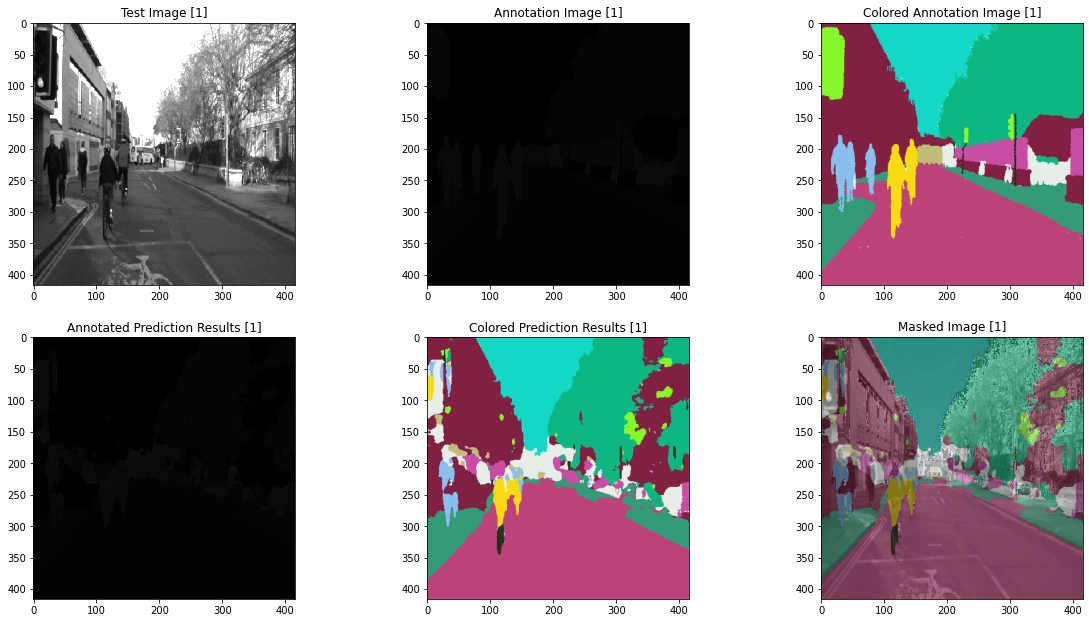

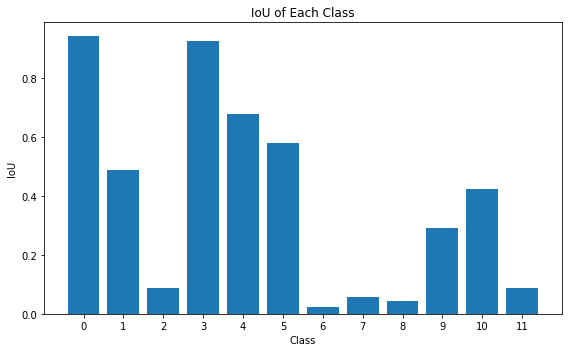

In [25]:
# testing the function
predict_annotation(test_x[0], test_y_cat[0], 1)

saving figure to: /content/drive/MyDrive/Course Indonesia AI - CV/Pertemuan 8 - Final Project/Prediction Image/

IoU of Each Class:
IoU Class 0: 91.57%
IoU Class 1: 55.00%
IoU Class 2: 6.29%
IoU Class 3: 87.96%
IoU Class 4: 83.16%
IoU Class 5: 46.59%
IoU Class 6: 10.26%
IoU Class 7: 22.74%
IoU Class 8: 32.56%
IoU Class 9: 44.03%
IoU Class 10: 57.66%
IoU Class 11: 14.00%
Mean IoU: 45.99%


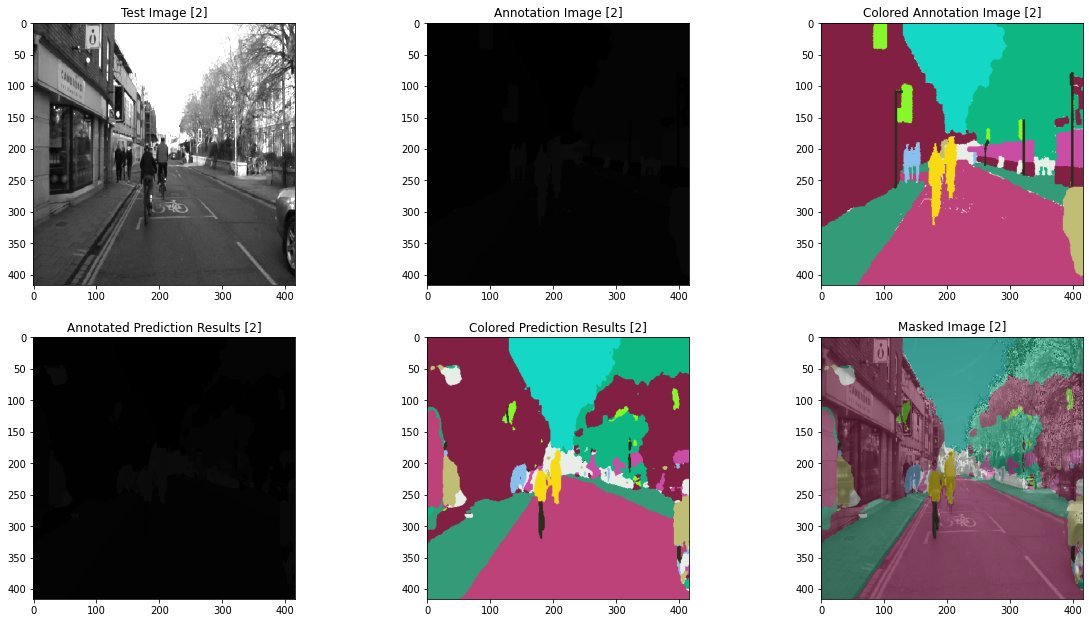

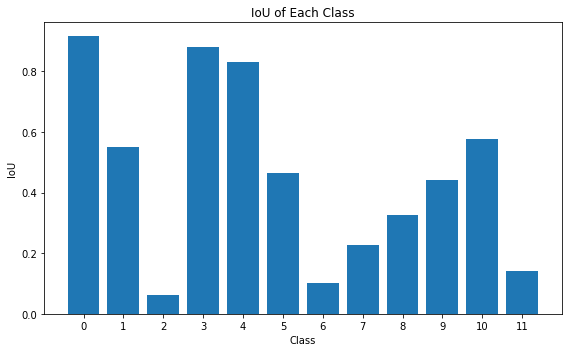

In [26]:
# testing the function
predict_annotation(test_x[1], test_y_cat[1], 2)

saving figure to: /content/drive/MyDrive/Course Indonesia AI - CV/Pertemuan 8 - Final Project/Prediction Image/

IoU of Each Class:
IoU Class 0: 89.94%
IoU Class 1: 72.13%
IoU Class 2: 1.23%
IoU Class 3: 95.98%
IoU Class 4: 84.89%
IoU Class 5: 63.13%
IoU Class 6: 6.20%
IoU Class 7: 1.61%
IoU Class 8: 51.81%
IoU Class 9: 1.92%
IoU Class 10: 24.13%
IoU Class 11: 5.69%
Mean IoU: 41.55%


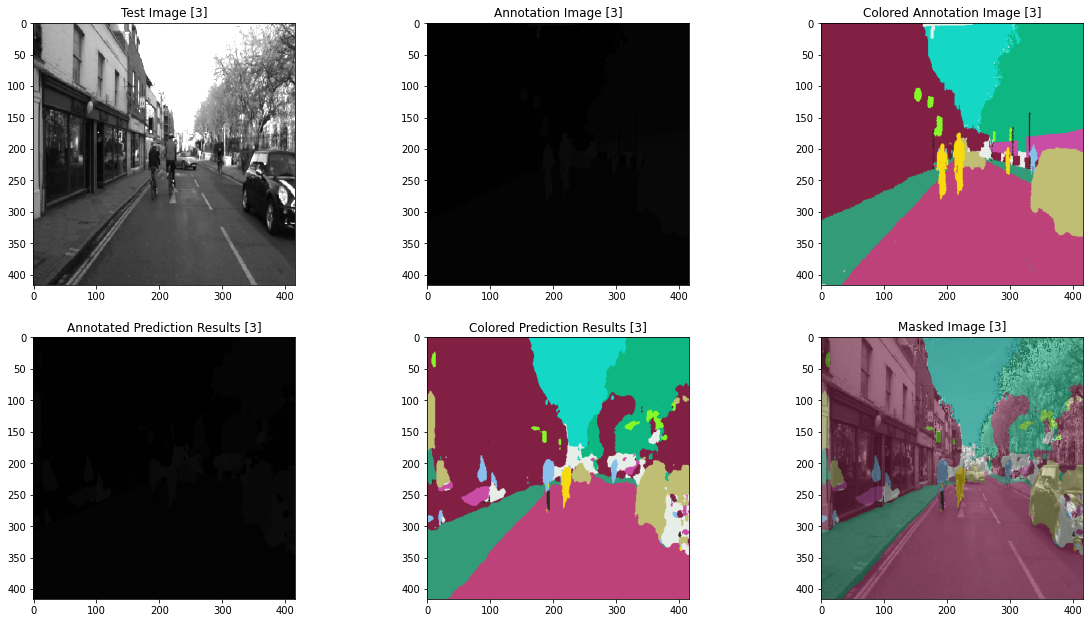

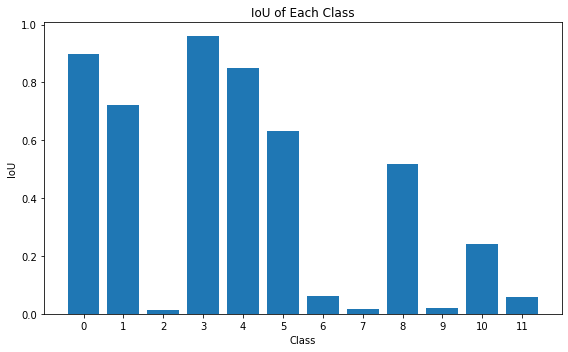

In [27]:
# testing the function
predict_annotation(test_x[2], test_y_cat[2], 3)